## PUI2016 FINAL EXAM

#### Hongting Chen(hc1924)

### Motivation and Goal

One of the things that make NYC so interesting to study is its diversity on many axes: ethnic, economic, cultural. Neighborohoods tend to be segregated and clustered on most socioeconomic characteristics, however these characteristics do evolve in time. The goal is to identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers (e.g. gentrification).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pylab as plt
import seaborn
import os 
import glob
import zipfile
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
from fiona.crs import from_epsg
from sklearn.cluster import KMeans

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### 1) Find the number of businesses in 2010 and 2000. 

In [98]:
# download census business data in 2000 and 2010
! wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip; 
    
! wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip; 

--2016-12-17 17:21:48--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2016-12-17 17:26:50--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
  (try: 2) => “zbp00totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434      344K/s   in 1.8s    

2016-12-17 17:26:52 (344 KB/s) - “zbp00totals.zip” saved [628434]

--2016-12-17 17:26:52--  f

In [2]:
path = os.getenv("PUIDATA")
os.chdir(os.getenv("PUIDATA"))
zbpfile = glob.glob("*.zip")

In [3]:
zf00 = zipfile.ZipFile(zbpfile[0])
buzzips2000 = pd.read_csv(zf00.open(zbpfile[0].replace('.zip','.txt')))
buzzips2000.head()

ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       A     0      0       0    1
1  1001      AGAWAM, MA     NaN  8042  59833  259661  493
2  1002     AMHERST, MA     NaN  6547  36719  169658  563
3  1003     AMHERST, MA     NaN    82    308    2482   13
4  1004     AMHERST, MA     NaN   717   2049    5826   48

In [4]:
zf10 = zipfile.ZipFile(zbpfile[1])
buzzips2010 = pd.read_csv(zf10.open(zbpfile[1].replace('.zip','.txt')))
buzzips2010.head()

zip            name empflag emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0   501  HOLTSVILLE, NY       A      D      0      D      0     D       0   
1  1001      AGAWAM, MA     NaN      G   9185      G  70693     G  314508   
2  1002     AMHERST, MA     NaN      G  15633      G  82069     G  351589   
3  1003     AMHERST, MA     NaN      G    168      H   1297     H    5761   
4  1004     AMHERST, MA     NaN      H    189      H   1710     H    7241   

   est        city stabbr   cty_name  
0    2  HOLTSVILLE     NY    SUFFOLK  
1  448      AGAWAM     MA    HAMPDEN  
2  570     AMHERST     MA  HAMPSHIRE  
3   16     AMHERST     MA  HAMPSHIRE  
4   21     AMHERST     MA  HAMPSHIRE

In [5]:
buzzips2000 = buzzips2000[['EST','ZIP']]
buzzips2010 = buzzips2010[['zip','est']]
buzzips2000.columns = [['EST2000','zipcodes']]
buzzips2010.columns = [['zipcodes','EST2010']]
bizzips = pd.merge(buzzips2000, buzzips2010, on = 'zipcodes')

In [6]:
# Census Business data in 2000
buzzips2000.head()

EST2000  zipcodes
0        1       501
1      493      1001
2      563      1002
3       13      1003
4       48      1004

In [7]:
# Census Business data in 2010
buzzips2010.head()

zipcodes  EST2010
0       501        2
1      1001      448
2      1002      570
3      1003       16
4      1004       21

In [8]:
bizzips.head()

EST2000  zipcodes  EST2010
0        1       501        2
1      493      1001      448
2      563      1002      570
3       13      1003       16
4       48      1004       21

### 2) Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile.

In [69]:
# download the nyc zipcode shapefile
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip
!mv ZIP* os.getenv("PUIDATA")

--2016-12-17 16:56:19--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.140.199
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2016-12-17 16:56:19--  https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.1”

100%[======================================>] 1,514,401   1.87M/s   in 0.8s    

2016-12-17 16:56:20 (1.87 MB/s) - “application%2Fzip.1” saved [1514401/1514401]

Archive:  application%2Fzip
replace ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename:

In [9]:
nyczipsshp = gp.GeoDataFrame.from_file( os.getenv("PUIDATA") + 
                                    '/ZIP_CODE_040114.shx')
nyczipsshp['zipcodes'] =  nyczipsshp.ZIPCODE.astype(int) 
nyczipsshp.drop(['ZIPCODE'], axis = 1, inplace = True)

In [10]:
# Coordinate systems, projections, and transformations

In [11]:
# calculate the area of each zipcode, unit: mi2
nyczipsshp['zip_area'] = nyczipsshp.geometry.area/(2.788 * 10**7)
#convert coordinate system, epsg=4326: lat/on 
nyczipsshp = nyczipsshp.to_crs(epsg = 4326)

In [12]:
nyczipsshp.head(3)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   
2  4.197210e+07       0   Kings      047     83866.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL  \
0        0.0    NY      36  http://www.usps.com/   
1        0.0    NY      36  http://www.usps.com/   
2        0.0    NY      36  http://www.usps.com/   

                                            geometry  zipcodes  zip_area  
0  POLYGON ((-73.80584847647386 40.6829093264758,...     11436  0.814178  
1  POLYGON ((-73.93739763139808 40.67972958928415...     11213  1.062805  
2  POLYGON ((-73.90294132545432 40.6708397759334,...     11212  1.505456

In [13]:
# merge the number of businesses with the zipcode shapfile
nyczbp = pd.merge(nyczipsshp, bizzips, on = 'zipcodes')

In [14]:
nyczbp.head(3)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   
2  4.197210e+07       0   Kings      047     83866.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL  \
0        0.0    NY      36  http://www.usps.com/   
1        0.0    NY      36  http://www.usps.com/   
2        0.0    NY      36  http://www.usps.com/   

                                            geometry  zipcodes  zip_area  \
0  POLYGON ((-73.80584847647386 40.6829093264758,...     11436  0.814178   
1  POLYGON ((-73.93739763139808 40.67972958928415...     11213  1.062805   
2  POLYGON ((-73.90294132545432 40.6708397759334,...     11212  1.505456   

   EST2000  EST2010  
0       65       98  
1      477      675  
2      520      699

### 3) Find the density of businesses by dividing the number of businesses by the area of the zipcode and show them the density in a choroplath for 2000 and 2010. Also show the difference in business density between 2000 and 2010 in a map.

### When we use 'hot_r' (sequential colormaps) for the choroplaths, the lighter the color, the lower the value.

In [15]:
nyczbp['bdense2000'] = nyczbp['EST2000'] / nyczbp['zip_area']
nyczbp['bdense2010'] = nyczbp['EST2010'] / nyczbp['zip_area']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


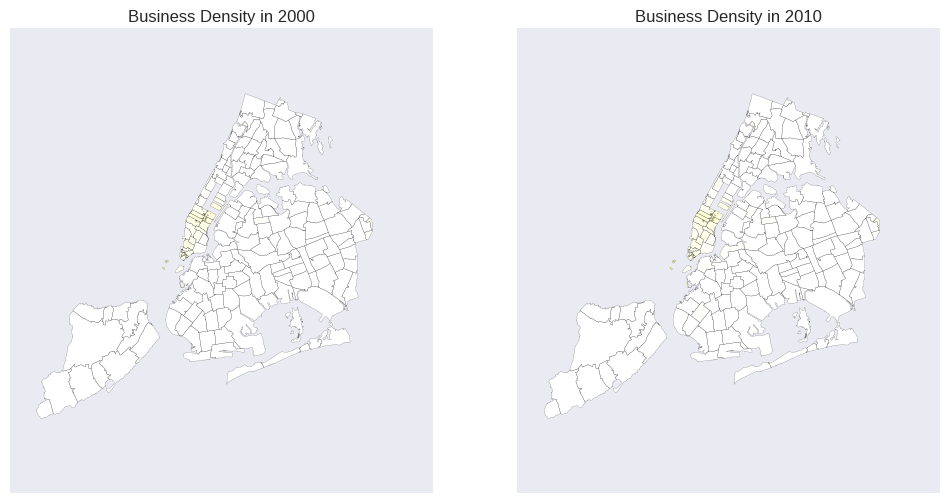

In [16]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nyczbp.plot(column = 'bdense2000', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax1)
ax1.set_title("Business Density in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nyczbp.plot(column = 'bdense2010', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax2)
ax2.set_title("Business Density in 2010")

#### Figure 1a, 1b: Choroplath of the business density (number of business within zipcode area) in New York. In both 2000 and 2010, it shows a big contrast in the business density between the midtown Manhattan and the rest of New York.

In [17]:
nyczbp['bizdiff'] = nyczbp['bdense2010'] - nyczbp['bdense2000']

In [18]:
nyczbp.head(3)

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   
2  4.197210e+07       0   Kings      047     83866.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL  \
0        0.0    NY      36  http://www.usps.com/   
1        0.0    NY      36  http://www.usps.com/   
2        0.0    NY      36  http://www.usps.com/   

                                            geometry  zipcodes  zip_area  \
0  POLYGON ((-73.80584847647386 40.6829093264758,...     11436  0.814178   
1  POLYGON ((-73.93739763139808 40.67972958928415...     11213  1.062805   
2  POLYGON ((-73.90294132545432 40.6708397759334,...     11212  1.505456   

   EST2000  EST2010  bdense2000  bdense2010     bizdiff  
0       65       98   79.835076  120.366730   40.531654  
1      477      675  448.812325  635.111781  186.299456  
2      520      699  345.410371  464.311249  118.900878

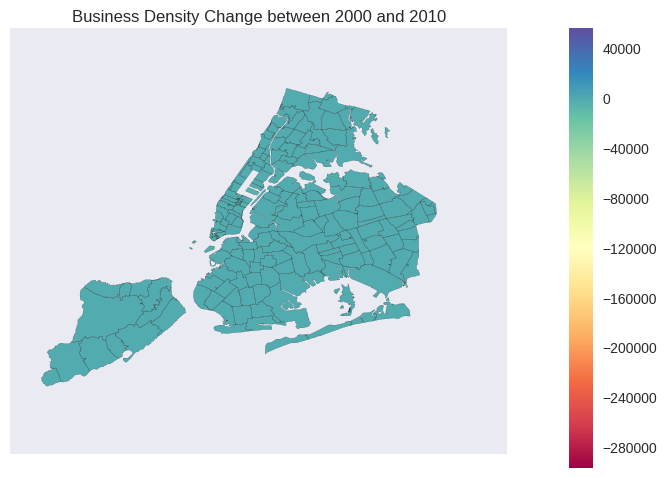

In [19]:
ax = nyczbp.plot(column='bizdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nyczbp['bizdiff'].values), \
            max(nyczbp['bizdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Business Density Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 2a: Map of the difference in business density between 2000 and 2010. It's safe to say business is booming in these 10 years in New York city.

In [20]:
nyczbpcut = nyczbp[nyczbp['bizdiff'] <= 1000]
nyczbpcut = nyczbpcut[nyczbpcut['bizdiff'] >= -1000]

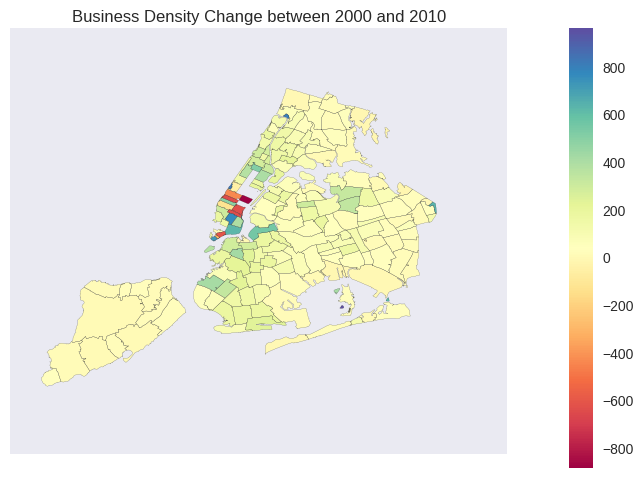

In [21]:
ax = nyczbpcut.plot(column='bizdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nyczbpcut['bizdiff'].values), \
            max(nyczbpcut['bizdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Business Density Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 2b:  To take a closer look at the change of business density between 2000 and 2010. I maped the areas whose change is within a certain degree. We can tell the drast change of business (both up and down) happens in midtown, areas around Manhattan show a certain degree of prospering, the rest of New York remains quite steady.

### 4) Collect census data from the 2010 and 2000 census and extract the estimate (mean or median) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

Download the data with SQL query from public data in cartoDB
    - Census 2000: DEC_00_SF1_DP1
    - Census 2010: DEC_10_SF1_SF1DP1
    - Income Census 2000: DEC_00_SF3_DP3_with_ann
    - Income Census 2010: ACS_10_5YR_S1901_with_ann


In [22]:
# define a helper function queryCartoDB wraps around the SQL API of CartoDB
SQL_SOURCE = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """queries data from CartoDB SQL database
    Arguments:
    query: a string like 
            SELECT colum_name_1, column_name_2 FROM database_name
    format: the file format (e.g. CSV, GeoJson)
    source: the sql database url link
    Return:
        database as a string to be read in with the appropriate function
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [23]:
# column content:
# hc01_vc01: total population
# hc02_vc29: white population percentage
# hc01_vc18: median age

Query = '''

SELECT the_geom, geo_id, hc01_vc01, hc02_vc29, hc01_vc18
FROM  dec_00_sf1_dp1 
 '''
    
datastream = queryCartoDB(Query, format = 'GeoJSON')
datageo  = json.loads(datastream.read())
SF1census2000 = gp.GeoDataFrame.from_features(datageo['features'])

In [24]:
SF1census2000.drop(['geometry'], axis = 1, inplace = True)
SF1census2000.columns = ['geo_id', 'population', 'age', 'diversity']
SF1census2000.diversity.replace('', np.nan, inplace = True)
SF1census2000.population = SF1census2000.population.astype(float)
SF1census2000.age = SF1census2000.age.astype(float)
SF1census2000.diversity = SF1census2000.diversity.astype(float)

In [25]:
# 2000 census
SF1census2000.head()

geo_id  population   age  diversity
0  1400000US36047054300         0.0   0.0        NaN
1  1400000US36081121100         0.0   0.0        NaN
2  1400000US36005003700       478.0  22.0       18.4
3  1400000US36005004900       246.0  30.0       20.7
4  1400000US36005005800         5.0  23.5        0.0

In [26]:
# column content:
# hd01_s001: total population
# hd02_s078: white population percentage
# hd01_s020: median age

Query = '''

SELECT the_geom, geo_id, hd01_s001, hd01_s020, hd02_s078
FROM  dec_10_sf1_sf1dp1 
 '''
    
datastream = queryCartoDB(Query, format = 'GeoJSON')
datageo  = json.loads(datastream.read())
SF1census2010 = gp.GeoDataFrame.from_features(datageo['features'])

In [27]:
SF1census2010.drop(['geometry'], axis = 1, inplace = True)
SF1census2010.columns = ['geo_id', 'population', 'age', 'diversity']
SF1census2010.diversity.replace('', np.nan, inplace = True)
SF1census2010.population = SF1census2010.population.astype(float)
SF1census2010.age = SF1census2010.age.astype(float)
SF1census2010.diversity = SF1census2010.diversity.astype(float)

In [28]:
# 2010 census
SF1census2010.head()

geo_id  population   age  diversity
0  1400000US36081038301         0.0   0.0        NaN
1  1400000US36005002400         4.0  38.0       50.0
2  1400000US36059990200         0.0   0.0        NaN
3  1400000US36059990400         0.0   0.0        NaN
4  1400000US36007012900      1532.0  59.8       98.2

### 5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

In [29]:
# column content:
# hc01_vc64: median income

Query = '''

SELECT the_geom, geo_id, hc01_vc64
FROM  dec_00_sf3_dp3_with_ann 
 '''
    
datastream = queryCartoDB(Query, format = 'GeoJSON')
datageo  = json.loads(datastream.read())
SF3census2000 = gp.GeoDataFrame.from_features(datageo['features'])

In [30]:
SF3census2000.drop(['geometry'], axis = 1, inplace = True)
SF3census2000.columns = ['geo_id', 'income']
SF3census2000.income.replace(0, np.nan, inplace = True)
SF3census2000.income = SF3census2000.income.astype(float)
SF3census2000.head(3)

geo_id   income
0  1400000US36089991900      NaN
1  1400000US36001013703  68929.0
2  1400000US36005000200  42539.0

In [31]:
# column content:
# hc01_est_vc13: median income

Query = '''

SELECT the_geom, geo_id, hc01_est_vc13
FROM  acs_10_5yr_s1901_with_ann 
 '''
    
datastream = queryCartoDB(Query, format = 'GeoJSON')
datageo  = json.loads(datastream.read())
SF3census2010 = gp.GeoDataFrame.from_features(datageo['features'])

In [32]:
SF3census2010.drop(['geometry'], axis = 1, inplace = True)
SF3census2010.columns = ['geo_id', 'income']

In [33]:
SF3census2010.income.replace('-', np.nan, inplace = True)
SF3census2010.income.replace('250,000+', '250000', inplace = True)
SF3census2010.income.replace('2,500-', '2500', inplace = True)
SF3census2010.income = SF3census2010.income.astype(float)
SF3census2010.head(3)

geo_id   income
0  1400000US36001000100  32333.0
1  1400000US36001000200  25354.0
2  1400000US36001000300  30932.0

### 6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

In [34]:
census2000 = pd.merge(SF1census2000, SF3census2000, on = 'geo_id')
census2000.head(3)

geo_id  population   age  diversity   income
0  1400000US36047054300         0.0   0.0        NaN      NaN
1  1400000US36081121100         0.0   0.0        NaN      NaN
2  1400000US36005003700       478.0  22.0       18.4  23750.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05c378cb10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f05c0073a10>]], dtype=object)

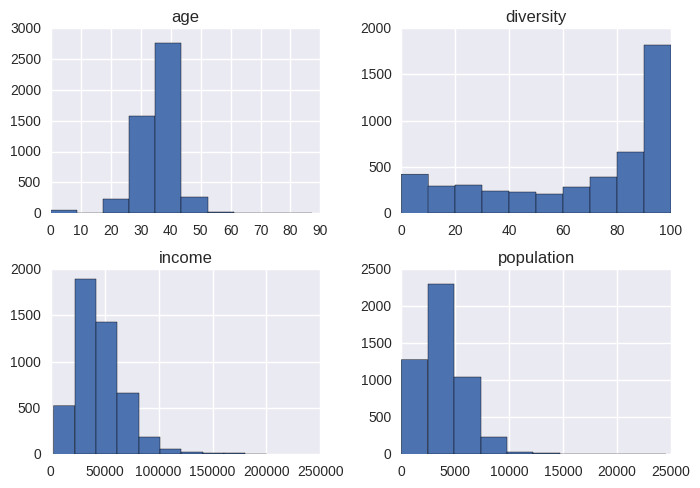

In [35]:
census2000.hist()

#### Figure 3a: Histogram of the features in New York City census tract level in 2000.

In [36]:
census2010 = pd.merge(SF1census2010, SF3census2010, on = 'geo_id')
census2010.head(3)

geo_id  population   age  diversity  income
0  1400000US36081038301         0.0   0.0        NaN     NaN
1  1400000US36005002400         4.0  38.0       50.0     NaN
2  1400000US36059990200         0.0   0.0        NaN     NaN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05bbd59410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f05bb049890>]], dtype=object)

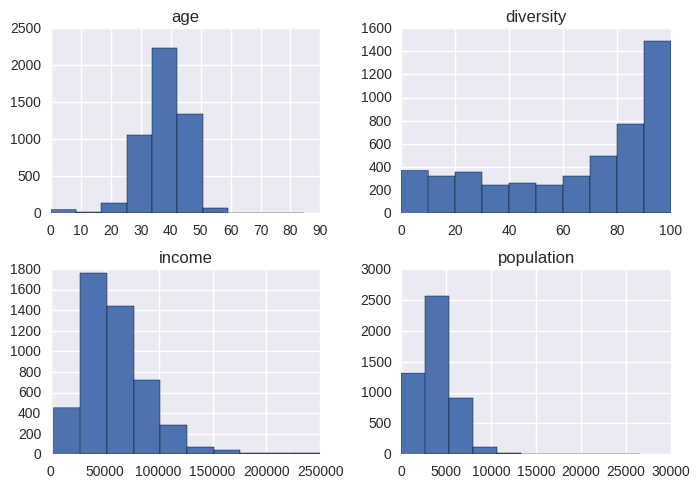

In [37]:
census2010.hist()

#### Figure 3b: Histogram of the features in New York City census tract level in 2010.

### 7) Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [38]:
# Download the census tracts shapefile with SQL query from public data in cartoDB
Query = '''

SELECT *
FROM  table_2010_census_tracts 
 '''
    
datastream = queryCartoDB(Query, format='GeoJSON')
datageo  = json.loads(datastream.read())
censustract = gp.GeoDataFrame.from_features(datageo['features'])
censustract.head(3)

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   

                 ntaname  puma     shape_area     shape_leng  
0               Flatbush  4015  1110945.63082  4305.94762341  
1     Stuyvesant Heights  4003  1743574.56294  5390.78775209  
2  Westchester-Unionport  3709  3278193.62083  9143.90356952

In [39]:
# There are changes in census tract geo between 2000 and 2010 due to the change of population
# here I use the same census tract shape file for 2000 and 2010
len(censustract)

2166

In [40]:
countyID = {'Bronx':'005',
       'Manhattan':'061',
       'Staten Island':'085',
       'Brooklyn':'047',
       'Queens':'081'}
censustract['allcodes'] = list(zip(censustract.boro_name, censustract.ct_2010))
censustract['geo_id']  = censustract[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))


In [41]:
censustract.head(3)

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   

                 ntaname  puma     shape_area     shape_leng  \
0               Flatbush  4015  1110945.63082  4305.94762341   
1     Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2  Westchester-Unionport  3709  3278193.62083  9143.90356952   

             allcodes                geo_id  
0  (Brooklyn, 050804)  1400000US36047050804  
1  (Brooklyn, 027500)  1400000US36047027500  
2     (Bronx, 009200)  1400000US36005009200

In [42]:
censusdt2000 = pd.merge(census2000, censustract, on = 'geo_id')
censusdt2000 = censusdt2000[['geo_id', 'population','diversity' ,'age', 'income', 'geometry']]
censusdt2000.head(3)

geo_id  population  diversity   age   income  \
0  1400000US36047054300         0.0        NaN   0.0      NaN   
1  1400000US36081121100         0.0        NaN   0.0      NaN   
2  1400000US36005003700       478.0       18.4  22.0  23750.0   

                                            geometry  
0  (POLYGON ((-73.97892899999999 40.705932, -73.9...  
1  (POLYGON ((-73.794676 40.747212, -73.79458 40....  
2  (POLYGON ((-73.910948 40.813621, -73.910308 40...

In [43]:
censusdt2010 = pd.merge(census2010, censustract, on = 'geo_id')
censusdt2010 = censusdt2010[['geo_id', 'population','diversity' ,'age', 'income', 'geometry']]
censusdt2010.head(3)

geo_id  population  diversity   age  income  \
0  1400000US36081038301         0.0        NaN   0.0     NaN   
1  1400000US36005002400         4.0       50.0  38.0     NaN   
2  1400000US36047008600         0.0        NaN   0.0     NaN   

                                            geometry  
0  (POLYGON ((-73.8369 40.762698, -73.836895 40.7...  
1  (POLYGON ((-73.870501 40.820364, -73.870435 40...  
2  (POLYGON ((-74.00066200000001 40.647487, -74.0...

In [44]:
len(censusdt2000)

1929

In [45]:
len(censusdt2010)

2166

In [46]:
# difference in the features

In [47]:
censusdt = pd.merge(censusdt2000, censusdt2010, on = 'geo_id', how = 'inner')
censusdt.columns = ['geo_id', 'population2000', 'diversity2000', 'age2000', 'income2000', 'geometry1',\
                   'population2010', 'diversity2010', 'age2010', 'income2010', 'geometry']
censusdt.drop(['geometry1'], axis = 1, inplace = True)

In [48]:
censusdt['popdiff'] = censusdt['population2010'] - censusdt['population2000']
censusdt['diverdiff'] = censusdt['diversity2010'] - censusdt['diversity2000']
censusdt['agediff'] = censusdt['age2010'] - censusdt['age2000']
censusdt['incomediff'] = censusdt['income2010'] - censusdt['income2000']

In [49]:
censusdt.head(3)

geo_id  population2000  diversity2000  age2000  income2000  \
0  1400000US36047054300             0.0            NaN      0.0         NaN   
1  1400000US36081121100             0.0            NaN      0.0         NaN   
2  1400000US36005003700           478.0           18.4     22.0     23750.0   

   population2010  diversity2010  age2010  income2010  \
0           327.0           70.9     33.8     31591.0   
1             0.0            NaN      0.0         NaN   
2           245.0           24.5     35.1     23304.0   

                                            geometry  popdiff  diverdiff  \
0  (POLYGON ((-73.97892899999999 40.705932, -73.9...    327.0        NaN   
1  (POLYGON ((-73.794676 40.747212, -73.79458 40....      0.0        NaN   
2  (POLYGON ((-73.910948 40.813621, -73.910308 40...   -233.0        6.1   

   agediff  incomediff  
0     33.8         NaN  
1      0.0         NaN  
2     13.1      -446.0

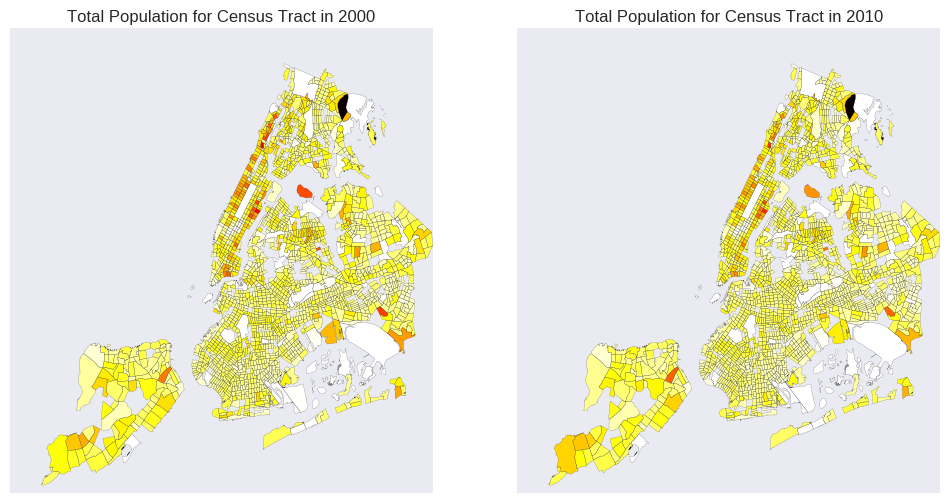

In [50]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
censusdt.plot(column = 'population2000', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax1)
ax1.set_title("Total Population for Census Tract in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
censusdt.plot(column = 'population2010', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax2)
ax2.set_title("Total Population for Census Tract in 2010")

#### Figure 4a, 4b: Map of total population in New York census tract level in 2000 and 2010. 

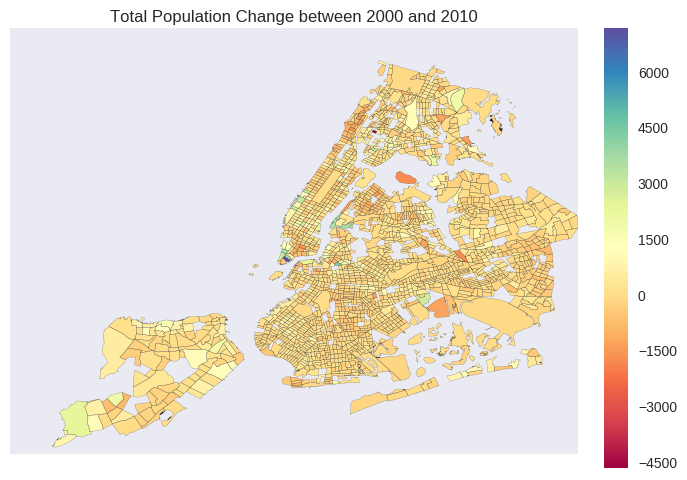

In [66]:
ax = censusdt.plot(column='popdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(censusdt['popdiff'].values), \
            max(censusdt['popdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Total Population Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 4c: Map of the difference in total polulation within census tract level between 2000 and 2010. Most areas remains the same level

In [51]:
censusdtvalid = censusdt.dropna()

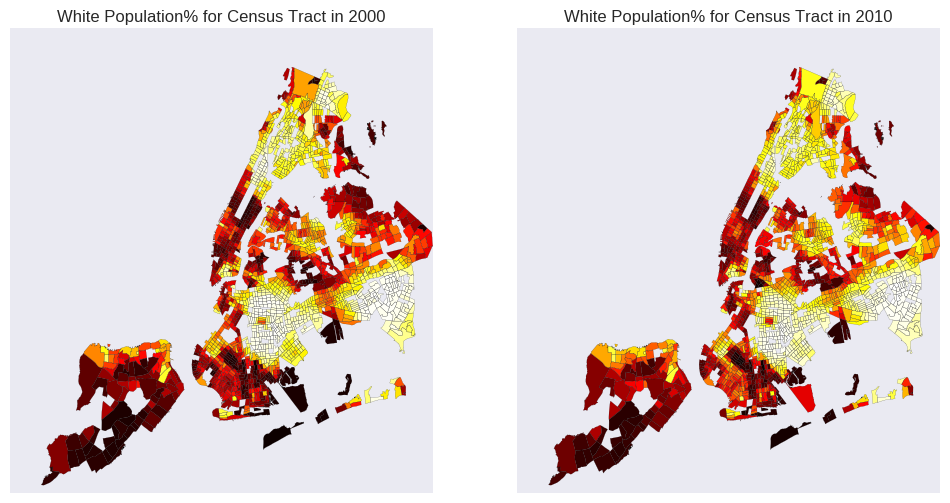

In [84]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
censusdtvalid.plot(column='diversity2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("White Population% for Census Tract in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
censusdtvalid.plot(column='diversity2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("White Population% for Census Tract in 2010")

#### Figure 5a, 5b: Map of white population percentage in New York census tract level in 2000 and 2010. The lighter the color, the lower the white population. We can intuitively tell there are areas located in Brooklyn, Queens have a very diverse population and it makes sense.

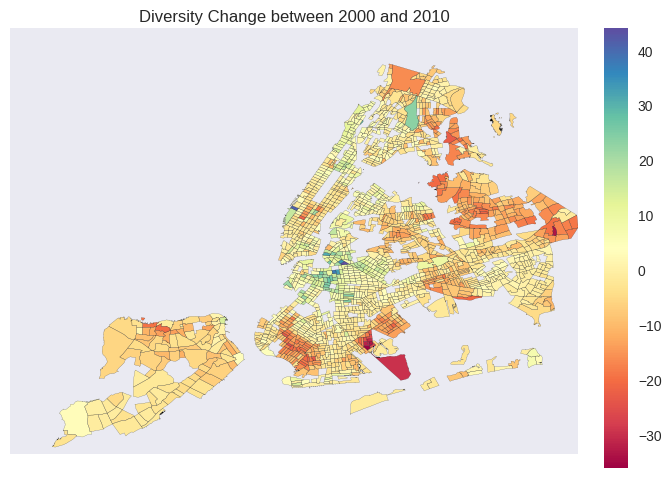

In [81]:
ax = censusdtvalid.plot(column='diverdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(censusdtvalid['diverdiff'].values), \
            max(censusdtvalid['diverdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Diversity Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 5c: Map of the difference in white polulation percentage within census tract level between 2000 and 2010.

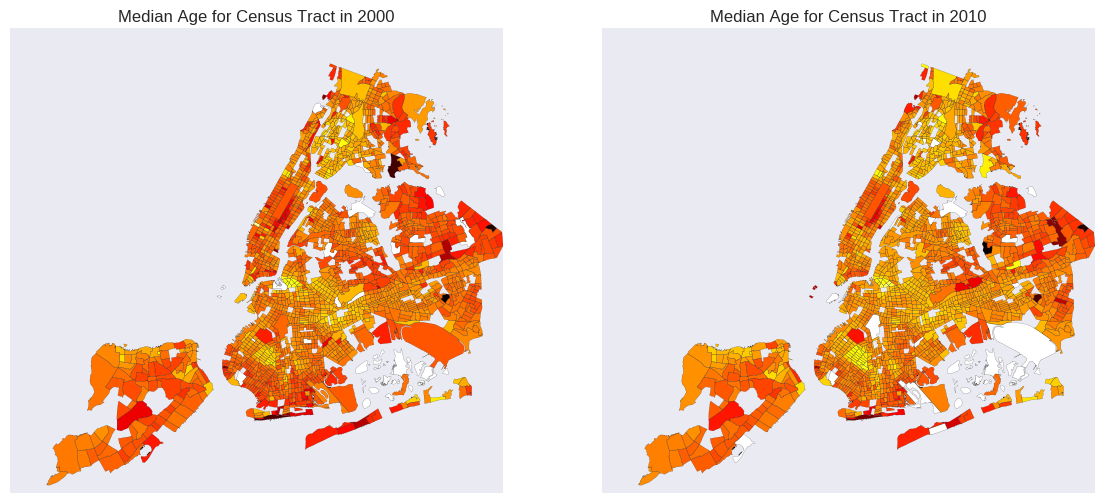

In [82]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(14)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
censusdt.plot(column='age2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Median Age for Census Tract in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
censusdt.plot(column='age2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Median Age for Census Tract in 2010")

#### Figure 6a, 6b: Map of median age in New York census tract level in 2000 and 2010.

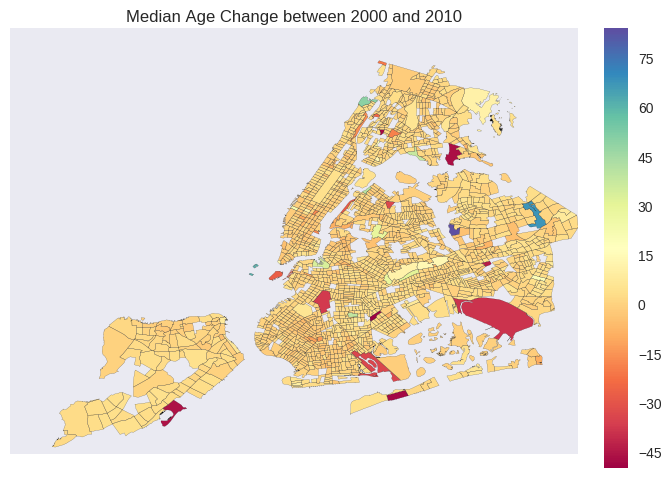

In [83]:
ax = censusdt.plot(column='agediff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(censusdt['agediff'].values), \
            max(censusdt['agediff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Median Age Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 6c: Map of the difference in median age within census tract level between 2000 and 2010.

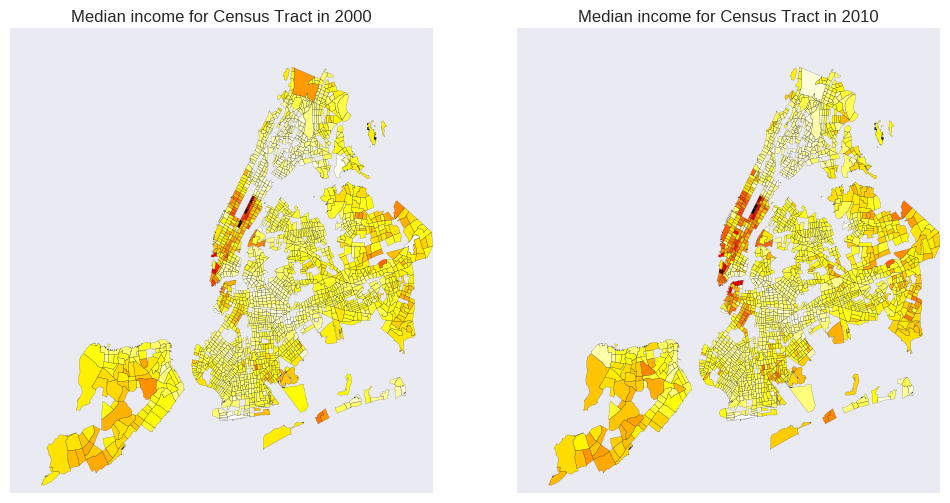

In [85]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
censusdtvalid.plot(column='income2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Median income for Census Tract in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
censusdtvalid.plot(column='income2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Median income for Census Tract in 2010")

#### Figure 7a, 7b: Map of median income in New York census tract level in 2000 and 2010.

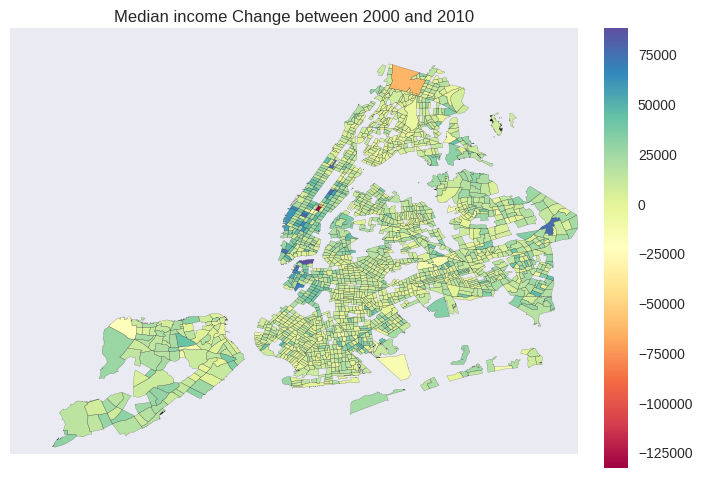

In [86]:
ax = censusdtvalid.plot(column='incomediff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(censusdtvalid['incomediff'].values), \
            max(censusdtvalid['incomediff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Median income Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 7c: Map of the difference in median income within census tract level between 2000 and 2010.

### 8) (OPTIONAL) Cluster the census tracts on these four features (using a Eucledian distance)

In [52]:
#to perform K-means I have to "whiten" the data!
from scipy.cluster.vq import whiten

In [53]:
censusdtvalid.population2000 = whiten(censusdtvalid.population2000)
censusdtvalid.diversity2000 = whiten(censusdtvalid.diversity2000)
censusdtvalid.age2000 = whiten(censusdtvalid.age2000)
censusdtvalid.income2000 = whiten(censusdtvalid.income2000)

censusdtvalid.population2010 = whiten(censusdtvalid.population2010)
censusdtvalid.diversity2010 = whiten(censusdtvalid.diversity2010)
censusdtvalid.age2010 = whiten(censusdtvalid.age2010)
censusdtvalid.income2010 = whiten(censusdtvalid.income2010)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [54]:
len(censusdtvalid)

1877

In [55]:
censusdtvalid.head(3)

geo_id  population2000  diversity2000   age2000  income2000  \
2  1400000US36005003700        0.221294       0.596436  3.832349    1.262655   
5  1400000US36047003700        0.165276       1.124800  6.689191    1.949379   
6  1400000US36047046400        1.174527       2.917349  3.971707    1.900149   

   population2010  diversity2010   age2010  income2010  \
2        0.114601       0.834011  5.969272    0.900432   
5        0.182426       1.702062  4.727800    2.907936   
6        1.327503       3.182857  3.350275    1.936756   

                                            geometry  popdiff  diverdiff  \
2  (POLYGON ((-73.910948 40.813621, -73.910308 40...   -233.0        6.1   
5  (POLYGON ((-73.985364 40.690667, -73.985104000...     33.0       15.3   
6  (POLYGON ((-73.976578 40.627573, -73.976515000...    301.0        3.5   

   agediff  incomediff  
2     13.1      -446.0  
5    -10.6     38593.0  
6     -3.1     14384.0

In [56]:
data2000 = censusdtvalid[['population2000', 'diversity2000', 'age2000', 'income2000']]
nc = 5
km1 = KMeans(n_clusters=nc, random_state=222)
km1.fit(data2000)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=222, tol=0.0001,
    verbose=0)

In [57]:
clusterc = km1.cluster_centers_ 

In [58]:
# give the kmeans a init point which is the cluster center of the 2000 clustering.
data2010 = censusdtvalid[['population2010', 'diversity2010', 'age2010', 'income2010']]
nc = 5
km2 = KMeans(n_clusters=nc, random_state=222, init=clusterc)
km2.fit(data2010)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


KMeans(copy_x=True,
    init=array([[ 1.2152 ,  0.66656,  5.97441,  2.37941],
       [ 1.33388,  2.44288,  6.73774,  2.46878],
       [ 3.45345,  0.92493,  5.59889,  1.52583],
       [ 1.61681,  0.86556,  4.98831,  1.30961],
       [ 2.82448,  2.7316 ,  6.74342,  4.01402]]),
    max_iter=300, n_clusters=5, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=222, tol=0.0001, verbose=0)

### 9) (OPTIONAL) Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. (Once you get through this, you have done most of the heavy lifting! The rest is building upon this work.)

In [59]:
censusdtvalid['cluster2000'] = km1.labels_
censusdtvalid['cluster2010'] = km2.labels_

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
censusdtvalid['cchange'] = 0
# identify the census tracts that have changed cluster assignment 
censusdtvalid["cchange"] = censusdtvalid.apply(lambda x: int(x.cluster2010 != x.cluster2000), axis = 1)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [61]:
censusdtvalid.head(3)

geo_id  population2000  diversity2000   age2000  income2000  \
2  1400000US36005003700        0.221294       0.596436  3.832349    1.262655   
5  1400000US36047003700        0.165276       1.124800  6.689191    1.949379   
6  1400000US36047046400        1.174527       2.917349  3.971707    1.900149   

   population2010  diversity2010   age2010  income2010  \
2        0.114601       0.834011  5.969272    0.900432   
5        0.182426       1.702062  4.727800    2.907936   
6        1.327503       3.182857  3.350275    1.936756   

                                            geometry  popdiff  diverdiff  \
2  (POLYGON ((-73.910948 40.813621, -73.910308 40...   -233.0        6.1   
5  (POLYGON ((-73.985364 40.690667, -73.985104000...     33.0       15.3   
6  (POLYGON ((-73.976578 40.627573, -73.976515000...    301.0        3.5   

   agediff  incomediff  cluster2000  cluster2010  cchange  
2     13.1      -446.0            3            3        0  
5    -10.6     38593.0            0            3        1  
6     -3.1     14384.0            3            3        0

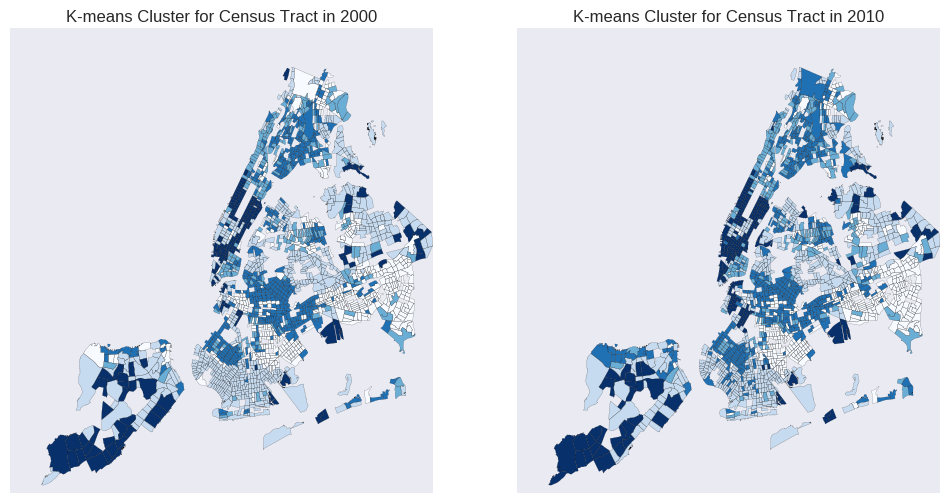

In [108]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
censusdtvalid.plot(column='cluster2000',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("K-means Cluster for Census Tract in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
censusdtvalid.plot(column='cluster2010',colormap='Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("K-means Cluster for Census Tract in 2010")

#### Figure 8a, 8b: Cluster map of socioeconomic characteristics in New York census tract level in 2000 and 2010.

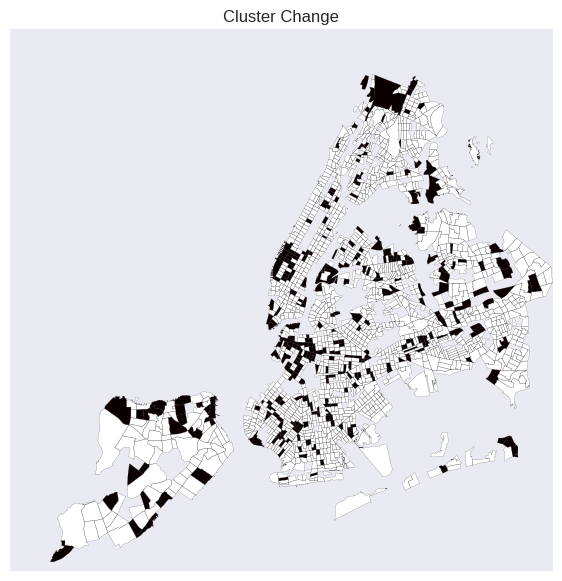

In [62]:
f, ax = plt.subplots(figsize=(7,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
censusdtvalid.plot(column='cchange',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Cluster Change")

#### Figure 8c: Map of the change in cluster within census tract level between 2000 and 2010. Dark blocks means the clusters have changed. The clusters of a certain amount of census tracts have changed.

### 10) Aggregate the census four features at the zipcode level and merge the zipcode dataframe

In [63]:
#'Bronx':'005',
#'Manhattan(New York)':'061',
#'Staten Island(Richmond)':'085',
#'Brooklyn(Kings)':'047',
#'Queens':'081'}
nyczbp.COUNTY.replace('Bronx', '005', inplace = True)
nyczbp.COUNTY.replace('New York', '061', inplace = True)
nyczbp.COUNTY.replace('Kings', '047', inplace = True)
nyczbp.COUNTY.replace('Richmond', '085', inplace = True)
nyczbp.COUNTY.replace('Queens', '081', inplace = True)

In [64]:
nyczbpBronx = nyczbp[nyczbp.COUNTY == '005']
nyczbpMan = nyczbp[nyczbp.COUNTY == '061']
nyczbpBrook = nyczbp[nyczbp.COUNTY == '047']
nyczbpQuee = nyczbp[nyczbp.COUNTY == '081']
nyczbpStaten = nyczbp[nyczbp.COUNTY == '085']

In [65]:
censusdt_raw = censusdt.dropna()
len(censusdt_raw)

1877

In [66]:
censusdt_raw['zipcodes'] = 0

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [67]:
for i, ct in censusdt_raw.iterrows():
    
    countycode =  censusdt_raw.loc[i].geo_id[11:14]
    cenpoint = censusdt_raw.loc[i].geometry.centroid
    
    if countycode == '005': # Bronx
        for j, zipcode in nyczbpBronx.iterrows():
            if nyczbpBronx.loc[j].geometry.contains(cenpoint) == True:
                censusdt_raw.set_value(i, 'zipcodes',nyczbpBronx.loc[j]['zipcodes'])
            
    elif countycode == '061': # Manhattan
        for j, zipcode in nyczbpMan.iterrows():
            if nyczbpMan.loc[j].geometry.contains(cenpoint) == True:
                censusdt_raw.set_value(i, 'zipcodes',nyczbpMan.loc[j]['zipcodes'])
    
    elif countycode == '047': # Brooklyn
        for j, zipcode in nyczbpBrook.iterrows():
            if nyczbpBrook.loc[j].geometry.contains(cenpoint) == True:
                censusdt_raw.set_value(i, 'zipcodes',nyczbpBrook.loc[j]['zipcodes'])
    
    elif countycode == '081': # Queens
        for j, zipcode in nyczbpQuee.iterrows():
            if nyczbpQuee.loc[j].geometry.contains(cenpoint) == True:
                censusdt_raw.set_value(i, 'zipcodes',nyczbpQuee.loc[j]['zipcodes'])
    
    elif countycode == '085': # Staten Island
        for j, zipcode in nyczbpStaten.iterrows():
            if nyczbpStaten.loc[j].geometry.contains(cenpoint) == True:
                censusdt_raw.set_value(i, 'zipcodes',nyczbpStaten.loc[j]['zipcodes'])
     

In [68]:
censusdt_raw.head(3)

geo_id  population2000  diversity2000  age2000  income2000  \
2  1400000US36005003700           478.0           18.4     22.0     23750.0   
5  1400000US36047003700           357.0           34.7     38.4     36667.0   
6  1400000US36047046400          2537.0           90.0     22.8     35741.0   

   population2010  diversity2010  age2010  income2010  \
2           245.0           24.5     35.1     23304.0   
5           390.0           50.0     27.8     75260.0   
6          2838.0           93.5     19.7     50125.0   

                                            geometry  popdiff  diverdiff  \
2  (POLYGON ((-73.910948 40.813621, -73.910308 40...   -233.0        6.1   
5  (POLYGON ((-73.985364 40.690667, -73.985104000...     33.0       15.3   
6  (POLYGON ((-73.976578 40.627573, -73.976515000...    301.0        3.5   

   agediff  incomediff  zipcodes  
2     13.1      -446.0     10454  
5    -10.6     38593.0     11201  
6     -3.1     14384.0     11204

In [69]:
zipdt_raw = censusdt_raw.groupby(['zipcodes']).mean()

In [70]:
zipdt_raw['zipcodes'] = zipdt_raw.index
zipdt_raw.head(3)

population2000  diversity2000    age2000    income2000  \
zipcodes                                                           
0            3656.450000      80.035000  34.980000  56428.550000   
10001        2149.333333      63.566667  37.000000  53814.666667   
10002        6061.142857      35.821429  37.857143  25544.357143   

          population2010  diversity2010    age2010    income2010     popdiff  \
zipcodes                                                                       
0            4000.400000      83.295000  36.355000  73544.400000  343.950000   
10001        2610.000000      63.550000  34.633333  81678.666667  460.666667   
10002        5758.357143      40.385714  39.821429  41051.357143 -302.785714   

          diverdiff   agediff  incomediff  zipcodes  
zipcodes                                             
0          3.260000  1.375000    17115.85         0  
10001     -0.016667 -2.366667    27864.00     10001  
10002      4.564286  1.964286    15507.00     10002

In [71]:
zbpdt = nyczbp[['zipcodes', 'bdense2000', 'bdense2010', 'bizdiff', 'geometry']]

In [72]:
nycall = pd.merge(zbpdt,zipdt_raw, on = 'zipcodes')
nycall.head(3)

zipcodes  bdense2000  bdense2010     bizdiff  \
0     11436   79.835076  120.366730   40.531654   
1     11213  448.812325  635.111781  186.299456   
2     11212  345.410371  464.311249  118.900878   

                                            geometry  population2000  \
0  POLYGON ((-73.80584847647386 40.6829093264758,...     2061.700000   
1  POLYGON ((-73.93739763139808 40.67972958928415...     3965.812500   
2  POLYGON ((-73.90294132545432 40.6708397759334,...     4426.388889   

   diversity2000    age2000    income2000  population2010  diversity2010  \
0       1.630000  33.250000  40976.600000     1993.300000       3.640000   
1      14.368750  29.600000  26933.437500     3843.437500      21.056250   
2       3.683333  28.427778  22683.777778     4353.666667       4.655556   

     age2010    income2010     popdiff  diverdiff  agediff    incomediff  
0  35.080000  62520.000000  -68.400000   2.010000    1.830  21543.400000  
1  31.875000  35751.812500 -122.375000   6.687500    2.275   8818.375000  
2  31.827778  28106.333333  -72.722222   0.972222    3.400   5422.555556

### 11) Repeat steps 7,8,9 at the zipcode level (NOT OPTIONAL AT THE ZIPCODE LEVEL) with the added feature (density of businesses).

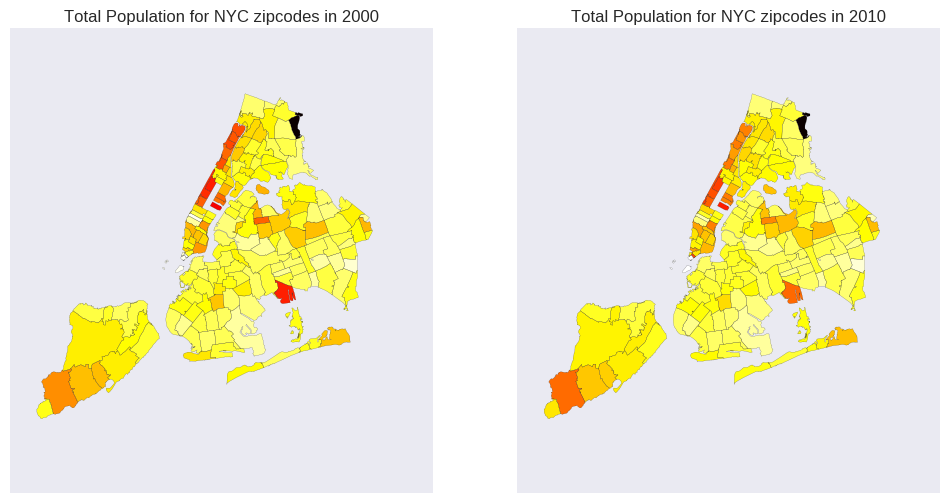

In [142]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column = 'population2000', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax1)
ax1.set_title("Total Population for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column = 'population2010', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax2)
ax2.set_title("Total Population for NYC zipcodes in 2010")

#### Figure 9a, 9b: Map of total population in New York zipcode level in 2000 and 2010.

In [74]:
nycalllimit = nycall[nycall['popdiff'] <= 5000]

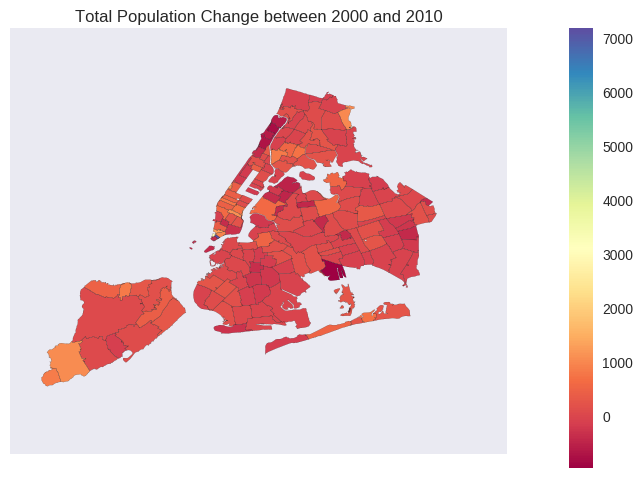

In [143]:
ax = nycall.plot(column='popdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycall['popdiff'].values), \
            max(nycall['popdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Total Population Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 9c_1: Map of the difference in total polulation within zipcode level between 2000 and 2010.

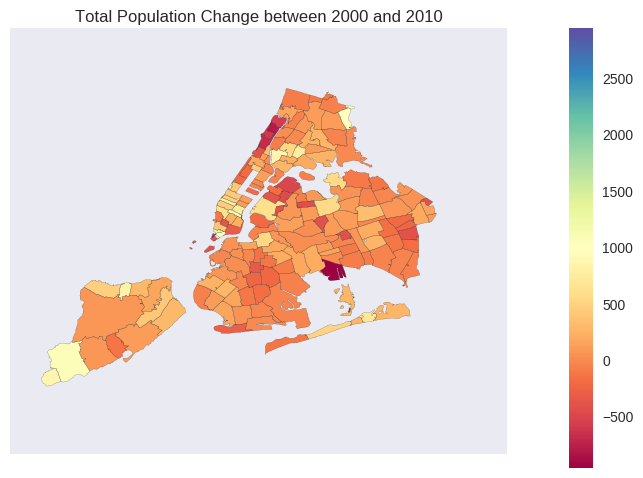

In [75]:
ax = nycalllimit.plot(column='popdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycalllimit['popdiff'].values), \
            max(nycalllimit['popdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Total Population Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 9c_2: Just to get a closer look.  Map of the difference in total polulation within zipcode level between 2000 and 2010.

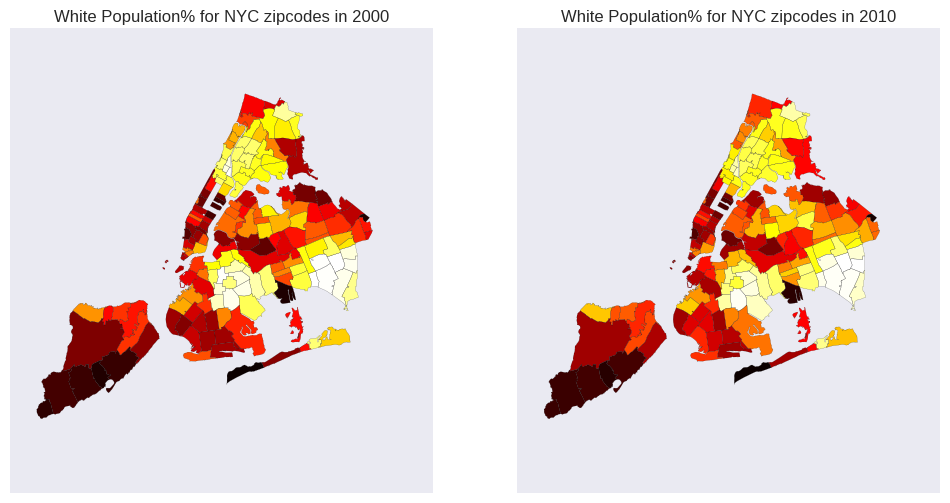

In [145]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column='diversity2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("White Population% for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column='diversity2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("White Population% for NYC zipcodes in 2010")

#### Figure 10a, 10b: Map of white population percentage in New York zipcode level in 2000 and 2010.

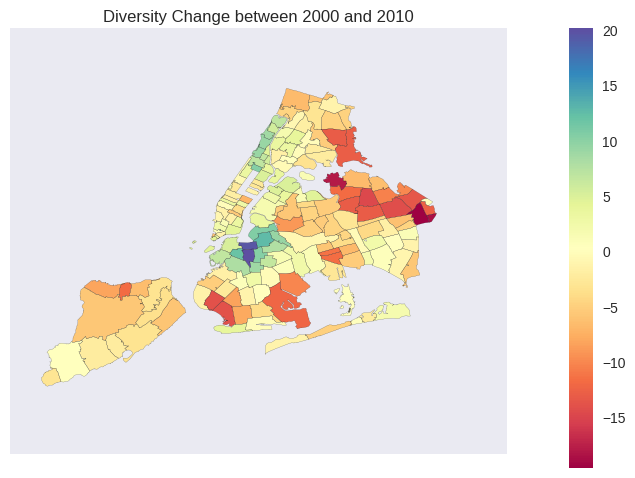

In [146]:
ax = nycall.plot(column='diverdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycall['diverdiff'].values), \
            max(nycall['diverdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Diversity Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 10c: Map of the difference in white polulation percentage within zipcode level between 2000 and 2010.

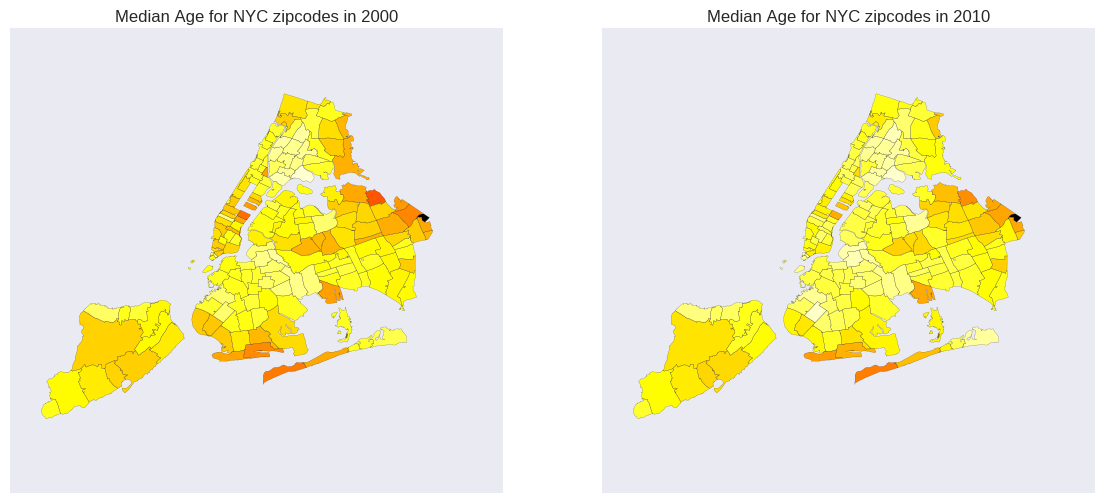

In [149]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(14)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column='age2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Median Age for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column='age2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Median Age for NYC zipcodes in 2010")

#### Figure 11a_1, 11b_1: Map of median age in New York zipcode level in 2000 and 2010. This plot is severely distorted by a data point which has a median age of 73.

In [83]:
max(nycall['age2000'])

73.0

In [84]:
# left out the outlier
nycalllimit = nycall[nycall['age2000'] <= 70]

In [85]:
len(nycalllimit)

182

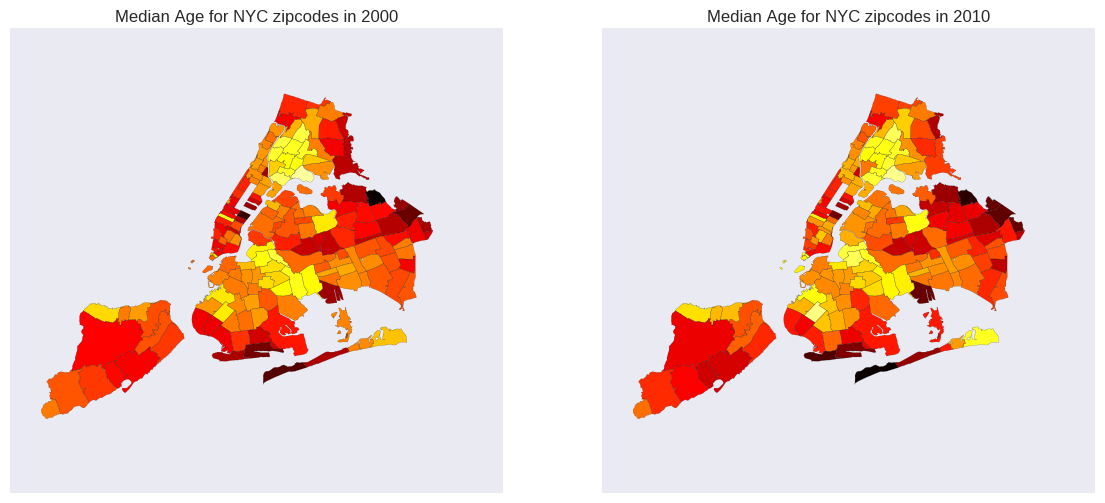

In [79]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(14)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycalllimit.plot(column='age2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Median Age for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycalllimit.plot(column='age2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Median Age for NYC zipcodes in 2010")

#### Figure 11a_2, 11b_2: Map of median age in New York zipcode level in 2000 and 2010.

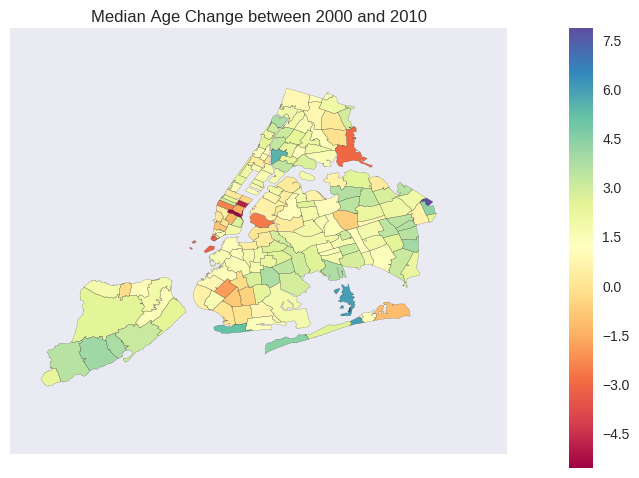

In [150]:
ax = nycall.plot(column='agediff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycall['agediff'].values), \
            max(nycall['agediff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Median Age Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 11c: Map of the difference in median age within zipcode level between 2000 and 2010.

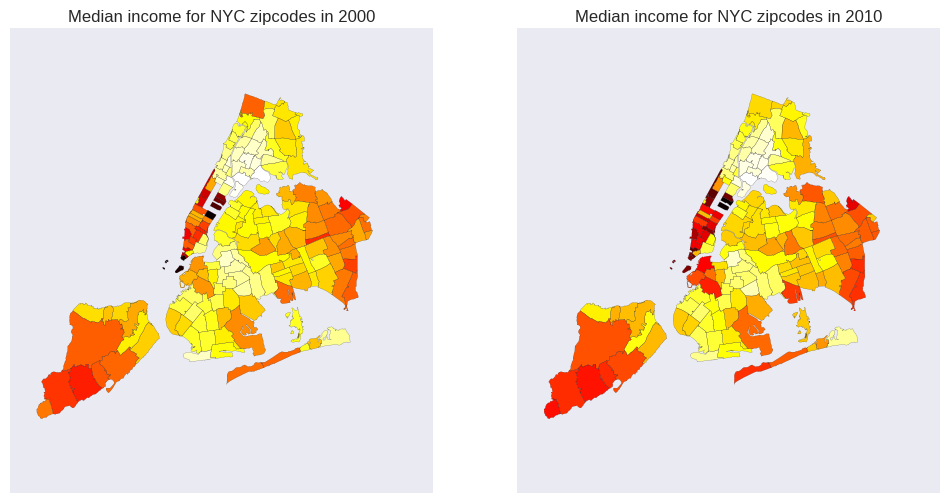

In [151]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column='income2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Median income for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column='income2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Median income for NYC zipcodes in 2010")

#### Figure 12a, 12b: Map of median income in New York zipcoded level in 2000 and 2010. Uptown Manhattan has the higheast income population. In general, people have gained income but the spatial pattern of median income remains the same. 

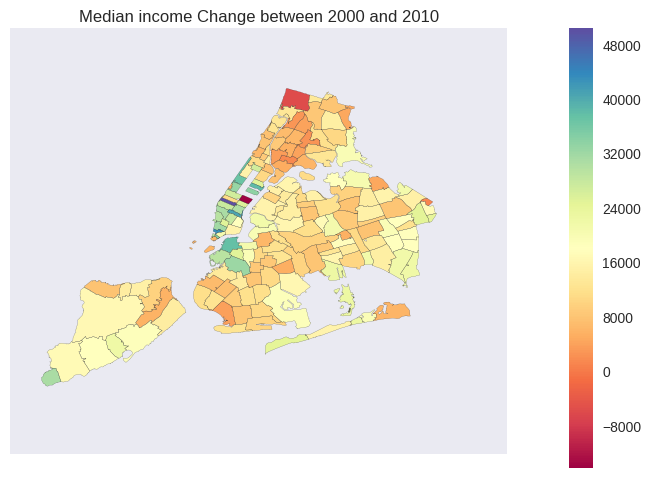

In [153]:
ax = nycall.plot(column='incomediff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycall['incomediff'].values), \
            max(nycall['incomediff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Median income Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 12c: Map of the difference in median income within zipcode level between 2000 and 2010. Manhattan shows the most drast change(both up and down) of the median income. Most New York shows a increase of income within these 10 years.

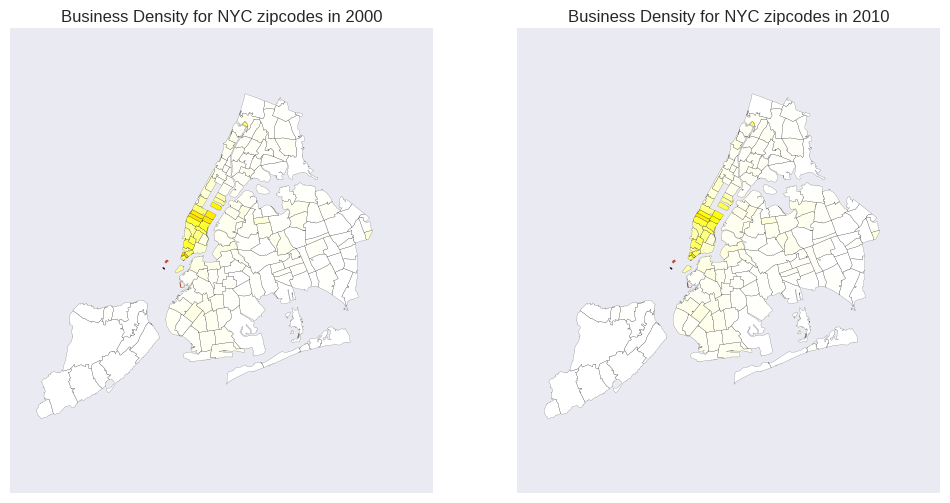

In [155]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column='bdense2000',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Business Density for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column='bdense2010',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Business Density for NYC zipcodes in 2010")

#### Figure 13a, 13b: Map of business density in New York zipcode level in 2000 and 2010. Midtown and downtown Manhattan has the most businesses of New York and the density drops as it radiated out from Manhattan.

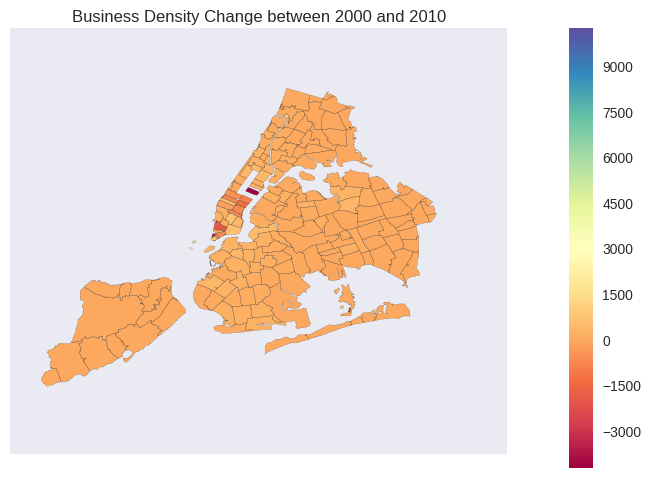

In [156]:
ax = nycall.plot(column='bizdiff', colormap='Spectral',alpha = 1, linewidth = 0.1)
vmin, vmax = min(nycall['bizdiff'].values), \
            max(nycall['bizdiff'].values)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Business Density Change between 2000 and 2010")
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
fig.colorbar(sm, cax = cax)

#### Figure 13c: Map of the difference in business density within zipcode level between 2000 and 2010. Most of New York has remained a steady business density level however midtown show a certain degree of decrease of businesses according to the plot.

In [88]:
#to perform K-means I have to "whiten" the data!
nycall.population2000 = whiten(nycall.population2000)
nycall.diversity2000 = whiten(nycall.diversity2000)
nycall.age2000 = whiten(nycall.age2000)
nycall.income2000 = whiten(nycall.income2000)
nycall.bdense2000 = whiten(nycall.bdense2000)

nycall.population2010 = whiten(nycall.population2010)
nycall.diversity2010 = whiten(nycall.diversity2010)
nycall.age2010 = whiten(nycall.age2010)
nycall.income2010 = whiten(nycall.income2010)
nycall.bdense2010 = whiten(nycall.bdense2010)

In [89]:
datazip2000 = nycall[['population2000', 'diversity2000', 'age2000', 'income2000', 'bdense2000']]
nc = 5
km3 = KMeans(n_clusters=nc, random_state=222)
km3.fit(datazip2000)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=222, tol=0.0001,
    verbose=0)

In [90]:
clusterc = km3.cluster_centers_ 

In [91]:
# give the kmeans a init point which is the cluster center of the 2000 clustering.
datazip2010 = nycall[['population2010', 'diversity2010', 'age2010', 'income2010', 'bdense2010']]
nc = 5
km4 = KMeans(n_clusters=nc, random_state=222, init=clusterc)
km4.fit(datazip2010)

KMeans(copy_x=True,
    init=array([[ 2.77691,  0.96777,  5.93745,  1.33103,  0.09901],
       [ 4.02236,  2.875  ,  7.29949,  3.53353,  0.9426 ],
       [ 1.01587,  2.65077,  6.56012,  4.55382,  3.42146],
       [ 1.79266,  0.98914,  6.54109,  2.32387,  0.06642],
       [ 2.08416,  2.53591,  7.45403,  2.45943,  0.2513 ]]),
    max_iter=300, n_clusters=5, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=222, tol=0.0001, verbose=0)

In [92]:
nycall['cluster2000'] = km3.labels_
nycall['cluster2010'] = km4.labels_

In [93]:
nycall['cchange'] = 0
# identify the census tracts that have changed cluster assignment 
nycall["cchange"] = nycall.apply(lambda x: int(x.cluster2000 != x.cluster2010), axis = 1)

In [94]:
nycall.head(3)

zipcodes  bdense2000  bdense2010     bizdiff  \
0     11436    0.012775    0.018138   40.531654   
1     11213    0.071817    0.095705  186.299456   
2     11212    0.055271    0.069967  118.900878   

                                            geometry  population2000  \
0  POLYGON ((-73.80584847647386 40.6829093264758,...        1.220691   
1  POLYGON ((-73.93739763139808 40.67972958928415...        2.348077   
2  POLYGON ((-73.90294132545432 40.6708397759334,...        2.620775   

   diversity2000   age2000  income2000  population2010  diversity2010  \
0       0.060064  6.446817    2.125822        1.144886       0.141926   
1       0.529479  5.739121    1.397278        2.207545       0.820998   
2       0.135728  5.511840    1.176810        2.500604       0.181523   

    age2010  income2010     popdiff  diverdiff  agediff    incomediff  \
0  6.292915    2.560140  -68.400000   2.010000    1.830  21543.400000   
1  5.717978    1.464006 -122.375000   6.687500    2.275   8818.375000   
2  5.709507    1.150930  -72.722222   0.972222    3.400   5422.555556   

   cluster2000  cluster2010  cchange  
0            3            3        0  
1            0            0        0  
2            0            0        0

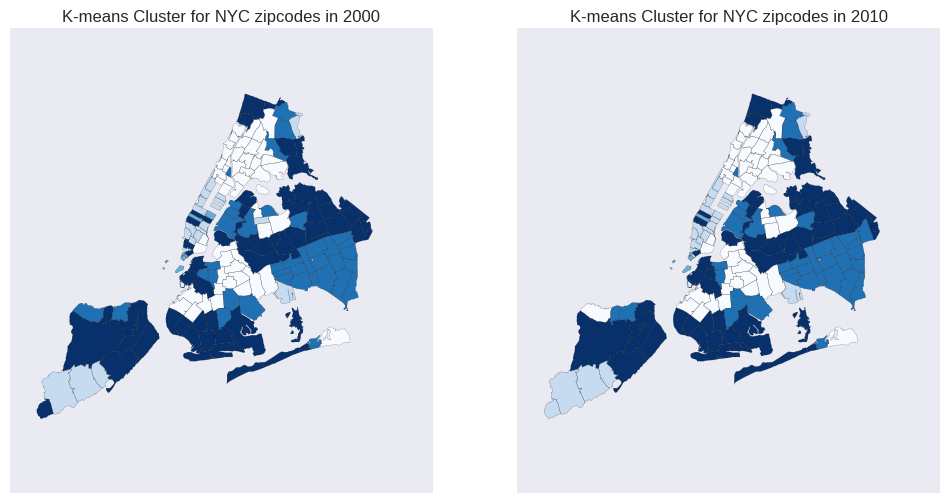

In [222]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(12)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
nycall.plot(column='cluster2000',colormap='Blues',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("K-means Cluster for NYC zipcodes in 2000")

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
nycall.plot(column='cluster2010',colormap='Blues',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("K-means Cluster for NYC zipcodes in 2010")

#### Figure 14a, 14b: Cluster map of socioeconomic characteristics in New York zipcode level in 2000 and 2010.

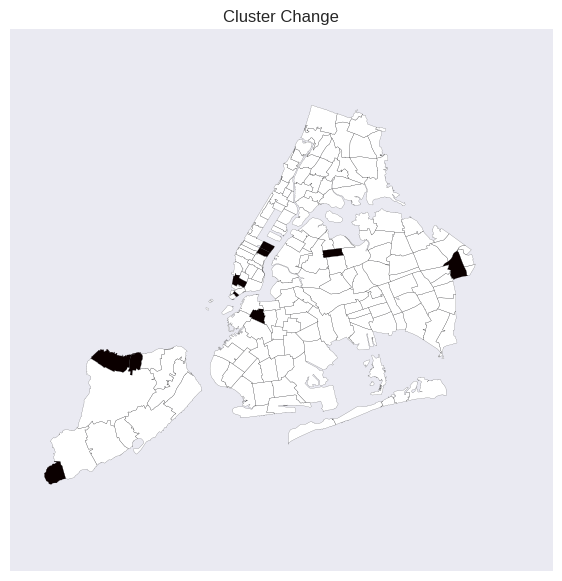

In [95]:
f, ax = plt.subplots(figsize=(7,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nycall.plot(column='cchange',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Cluster Change")

#### Figure 14c: Map of the change in cluster within zipcode level between 2000 and 2010.  Dark blocks mean the clusters have changed. Compared to the census tract level, we can see theere are fewer zipcode area changed cluster. It shows a steady pattern on how socioeconomic characteristics affect the city.

### 12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

In [101]:
import scipy.stats

In [98]:
def find_changed_area():
    nycall['cchange_'] = 0
    # identify the census tracts that have changed cluster assignment 
    nycall["cchange_"] = nycall.apply(lambda x: x.cluster2010 - x.cluster2000, axis = 1)
    
    ax = nycall.plot(column='cchange_', colormap='Spectral',alpha = 1, linewidth = 0.1)
    vmin, vmax = min(nycall['cchange_'].values), \
            max(nycall['cchange_'].values)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Areas whose Cluster Changed")
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    fig.colorbar(sm, cax = cax)

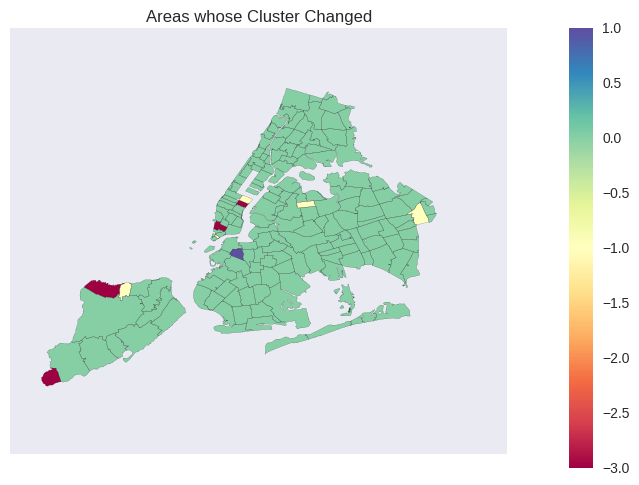

In [99]:
find_changed_area()

#### Figure 15:  Map of how zipcode areas have changed its cluster. The green blocks mean its cluster remains the same.

In [96]:
def plot_sigificantly_changed_features():
    cchangezip = nycall[nycall['cchange_'] != 0]
    cchangezips = cchangezip.zipcodes.astype(str)
    censusdt_raw.zipcodes = censusdt_raw.zipcodes.astype(str)
    
    cchangezipsdt = {}
    for i in cchangezips:
        cchangezipsdt[i] = censusdt_raw[censusdt_raw['zipcodes'] == i]
        
    csig_pop = []
    for i in cchangezips:
        data2000 = cchangezipsdt[i]['population2000']
        data2010 = cchangezipsdt[i]['population2010']
        pear = scipy.stats.pearsonr(data2000, data2010)
        if pear[0] <= 0.5:
            csig_pop.append(i)
            
    csig_age = []
    for i in cchangezips:
        data2000 = cchangezipsdt[i]['age2000']
        data2010 = cchangezipsdt[i]['age2010']
        pear = scipy.stats.pearsonr(data2000, data2010)
        if pear[0] <= 0.5:
            csig_age.append(i)
            
    csig_income = []
    for i in cchangezips:
        data2000 = cchangezipsdt[i]['income2000']
        data2010 = cchangezipsdt[i]['income2010']
        pear = scipy.stats.pearsonr(data2000, data2010)
        if pear[0] <= 0.5:
            csig_income.append(i)
            
    #plot the features 
    csig_diver = []
    for i in cchangezips:
        data2000 = cchangezipsdt[i]['diversity2000']
        data2010 = cchangezipsdt[i]['diversity2010']
        pear = scipy.stats.pearsonr(data2000, data2010)
        if pear[0] <= 0.5:
            csig_diver.append(i)
 
    for i in csig_pop:
        fig = plt.figure(figsize = (6,4))
        plt.hist(cchangezipsdt[i]['population2000'], color = 'navy', alpha = 0.5, label = '2000')
        plt.hist(cchangezipsdt[i]['population2010'], color = 'indianred', alpha = 0.5, label = '2010')
        plt.title('Population distribution of zipcode {}'.format(i))
        plt.xlabel('Total Population')
        plt.ylabel('Number')
        plt.legend()
        

    for i in csig_diver:
        fig = plt.figure(figsize = (6,4))
        plt.hist(cchangezipsdt[i]['diversity2000'], color = 'navy', alpha = 0.5, label = '2000')
        plt.hist(cchangezipsdt[i]['diversity2010'], color = 'indianred', alpha = 0.5, label = '2010')
        plt.title('Diversity distribution of zipcode {}'.format(i))
        plt.xlabel('White Population%')
        plt.ylabel('Number')
        plt.legend()
        
    for i in csig_income:
        fig = plt.figure(figsize = (6,4))
        plt.hist(cchangezipsdt[i]['income2000'], color = 'navy', alpha = 0.5, label = '2000')
        plt.hist(cchangezipsdt[i]['income2010'], color = 'indianred', alpha = 0.5, label = '2010')
        plt.title('Median Income distribution of zipcode {}'.format(i))
        plt.xlabel('Median Income')
        plt.ylabel('Number')
        plt.legend()
        
    for i in csig_age:
        fig = plt.figure(figsize = (6,4))
        plt.hist(cchangezipsdt[i]['age2000'], color = 'navy', alpha = 0.5, label = '2000')
        plt.hist(cchangezipsdt[i]['age2010'], color = 'indianred', alpha = 0.5, label = '2010')
        plt.title('Median Age distribution of zipcode {}'.format(i))
        plt.xlabel('Age')
        plt.ylabel('Counts')
        plt.legend()
       

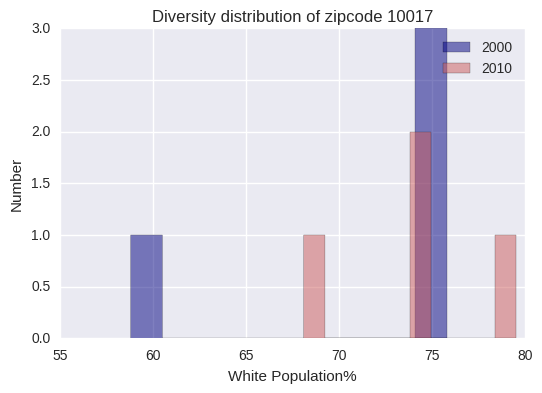

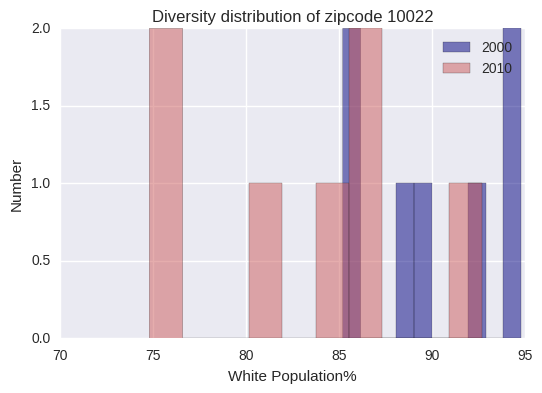

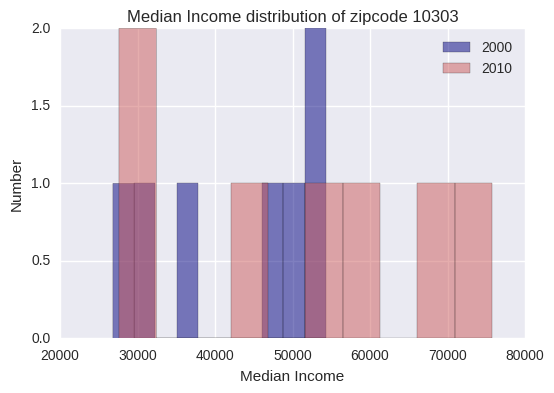

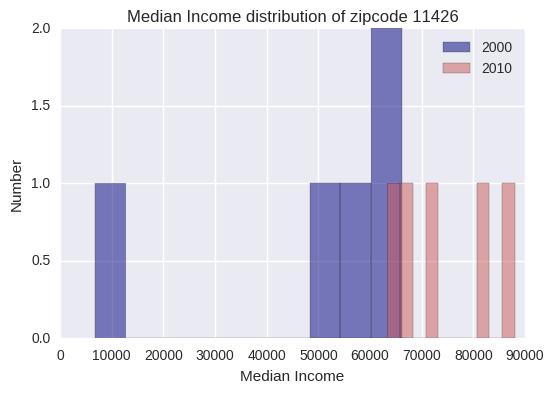

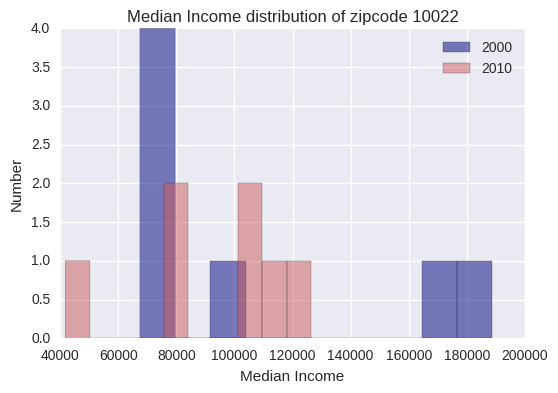

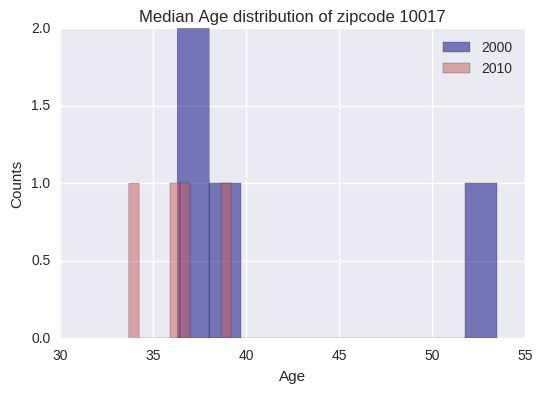

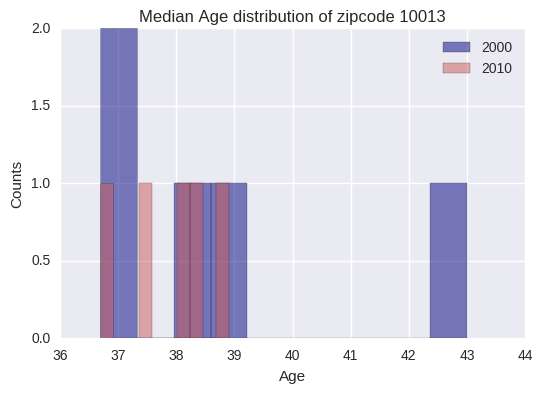

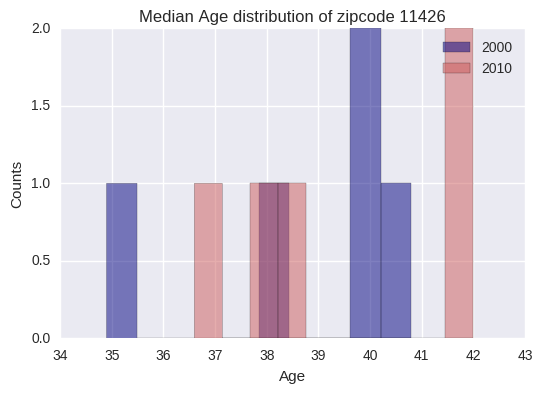

In [102]:
plot_sigificantly_changed_features()

#### Figure 16: Histogram of the features that have significantly changed measured by Pearson's correlation.

### 13) Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).

#### Through the analysis we clustered the socioeconomic characteristics(median age, median income, total population, white population%, business density) of New York, both in census tract level and zipcode level in 2000 and 2010.  And we find neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers. In general, the analysis is pretty standard and considers the socioeconomic fetures it can get and it gives the most intuitively results by plotting the choroplaths of the status of 2000 and 2010, and their changes. When perfomed on zipcode level and incorporated the business density, the cluster patterns show most of areas remain the same cluster. It indicates that most areas evolve the same with their cluster peears and it makes sense. The features are spatial correlated. However, I choosed 5 cluters, and could have performed more clutering number and get the most distinct result.